In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## Code for the Ising Model lives here ###

In [3]:
# Define the animation for the ising/demon model dashboard
def animate(i):
    # Run a step in the simulation and display the simulation image
    ising_model.perterb()
    im.set_data(ising_model.lattice)

    # Plot temp, magnetism, and system energy over monte carlo steps
    x_data = np.arange(1, ising_model.mcs + 1)
    temp_line.set_data(x_data, ising_model.temp)
    mag_line.set_data(x_data, ising_model.magnetization_data)
    sys_energy_line.set_data(x_data, ising_model.system_energy_data)

    # Reset the scale and limits of the plots
    ax[0, 0].relim()
    ax[0, 0].autoscale_view(True, True, True)
    ax[0, 1].relim()
    ax[0, 1].autoscale_view(True, True, True)
    ax[1, 0].relim()
    ax[1, 0].autoscale_view(True, True, True)
    ax[1, 1].relim()
    ax[1, 1].autoscale_view(True, True, True)

In [55]:
class IsingDemon:

    def __init__(self, N, target):
        self.N = N
        self.target = target

        self.demon_energy = 0
        self.system_energy = 0
        self.magnetization = 0

        self.system_energy_accum = 0
        self.mag_accum = 0
        self.mag_squared_accum = 0
        self.demon_energy_accum = 0

        self.magnetization_data = list()
        self.mag_squared_data = list()
        self.system_energy_data = list()
        self.demon_energy_data = list()
        self.temp = list()

        self.mcs = 0
        self.lattice = np.zeros([self.N, self.N], dtype=np.int8)

    def initialize_system(self):
        """ Initialize a system to all + spins, """
        self.lattice = np.ones([self.N, self.N], dtype=np.int8)

        E = -self.N ** 2
        self.magnetization = self.N ** 2

        # Try up to 10*N**2 times to flip spins so that the system has the desired energy
        while E < self.target:
            x, y = self._pick_random_site()
            dE = self._compute_change_energy((x, y))

            if dE > 0:
                E += dE
                new_spin = -1 * self.lattice[y, x]
                self.lattice[y, x] = new_spin
                self.magnetization += 2 * new_spin

        self.system_energy = E

    def reset(self):
        """ Resets the simulation """
        self.demon_energy = 0
        self.system_energy = 0
        self.magnetization = 0

        self.system_energy_accum = 0
        self.mag_accum = 0
        self.mag_squared_accum = 0
        self.demon_energy_accum = 0

        self.magnetization_data = list()
        self.mag_squared_data = list()
        self.system_energy_data = list()
        self.demon_energy_data = list()
        self.temp = list()
        
        self.mcs = 0
        self.lattice = np.zeros([self.N, self.N])

    def perterb(self):
        """ Randomly perturbs N^2 sights, and computes the system's change in energy """
        self.mcs += 1
        for i in range(0, self.N ** 2):
            # Pick a random site to perterb
            x, y = self._pick_random_site()

            # Flip the spin and compute the change in energy, delta E
            dE = self._compute_change_energy((x, y))

            # System gives the energy to the demon, accepts change
            if dE <= self.demon_energy:
                new_spin = -1 * self.lattice[y, x]
                self.lattice[y, x] = new_spin
                self.demon_energy -= dE
                self.system_energy += dE
                self.magnetization += 2 * new_spin

        # Update total values
        self.system_energy_accum += self.system_energy
        self.demon_energy_accum += self.demon_energy
        self.mag_accum += self.magnetization
        self.mag_squared_accum += self.magnetization**2

        # Add values to lists for plotting
        self.magnetization_data.append(self.mag_accum / self.mcs)
        self.mag_squared_data.append(self.mag_squared_accum / self.mcs)
        self.system_energy_data.append(self.system_energy_accum / self.mcs)
        self.demon_energy_data.append(self.demon_energy_accum / self.mcs)
        self.temp.append(self.temperature())

    def temperature(self):
        """ Computes the temperature of the system """
        if self.demon_energy_accum == 0:
            return 0.0
        else:
            return 4.0 / np.log(1.0 + (4.0 * self.mcs * self.N * self.N) / self.demon_energy_accum)

    def _compute_change_energy(self, point):
        """ Computes the energy at any point on the lattice """
        x, y = point
        nn = self._sum_nearest_neighbors(point)
        return 2 * self.lattice[y, x] * nn

    def _sum_nearest_neighbors(self, point):
        """ Computes the nearest neighbors of a point """
        x, y = point
        right = self.lattice[y, (x + 1) % self.N]
        left = self.lattice[y, (x - 1) % self.N]
        up = self.lattice[(y - 1) % self.N, x]
        down = self.lattice[(y + 1) % self.N, x]

        return right + left + up + down

    def _pick_random_site(self):
        """ Returns a random point on the lattice """
        i = np.random.randint(0, self.N)
        j = np.random.randint(0, self.N)
        return i, j

### (a) Simulate the Ising model on a square lattice using the demon algorithm ###

I chose to run a simple simulation with a lattice size of 50x50 and a starting target energy of -1000 for this first configuration. I run the simulation for 250 monte carlo steps to strike a balance between computation time and showing an equilibrium state. Clear "spin domains" can be seen as this system reaches an equilibrium state within the first 100 or less monte carlo steps. This run is to display the dashboard, as well as the convergent properties of the model.

In [54]:
# Create an Ising model with a Demon
ising_model = IsingDemon(50, -100)
ising_model.initialize_system()

# Initialize the dashboard
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
im = ax[0, 0].imshow(ising_model.lattice, cmap='Greys')
temp_line, = ax[0, 1].plot([], [], lw=3)
mag_line, = ax[1, 0].plot([], [], lw=3)
sys_energy_line, = ax[1, 1].plot([], [], lw=3)
ax[0, 0].set_title('System')
ax[0, 1].set_title('Temperature')
ax[1, 0].set_title('Magnetization')
ax[1, 1].set_title('System Energy')

# Animate the ising demon model
anim = FuncAnimation(fig, animate, interval=50, frames=500, repeat=False)
plt.close(fig)
HTML(anim.to_html5_video())

### (b) Compute $<E_d>$ and $<M^2>$ as a function of $E$ for $B = 0$. Choose $L = 20$ and run for at least 500 mcs. Use (15.10) to determine the dependence of $T$ on $E$ and plot $E$ versus $T$. ###

Below I've plotted scatterplots of (i) Demon Energy vs. System Energy, (ii) Magnetisation^2 vs System Energy, and (iii) Temperature vs System Energy

### (i) $<E_d>$ vs. E ####
For this plot it looks like there's a clear linear relationship between Demon Energy and System Energy. Which is what we would expect since if one increase it linearly decreases from the other and visa versa.

### (ii) $<M^2>$ vs. E ####
This plot is harder to interpret. There's clearly a sort of zig-zagging increase to the squared magnatisation of the system. Regardless of whether $E$ is increasing or decreasing, $<M^2>$ appears to take a slight step higher with each iteration. I'm not entirely sure of the physical justification for plotting $<M^2>$ as opposed to just $<M>$.

### (iii) T vs. E ####
This plot appears to converge to a value as the system energy moves to an equilbrium state. There is a collection of temperature values at 0.0 since with a lattice size of 20 it often takes a decent number of iterations before the demon starts collection energy. Thus, I've included a plot that skips the first half of the iterations and shows the system in an equilibrium state. With this plot you can see a clear linear relationship between T and E.

In [68]:
# Create an Ising model with a Demon
ising_model = IsingDemon(20, 100)
ising_model.initialize_system()

# Run an Ising model with demon for 500 monte carlo steps
for i in range(500):
    ising_model.perterb()

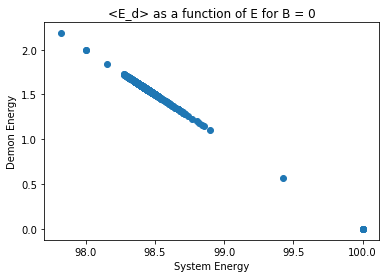

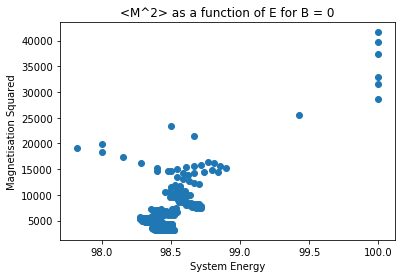

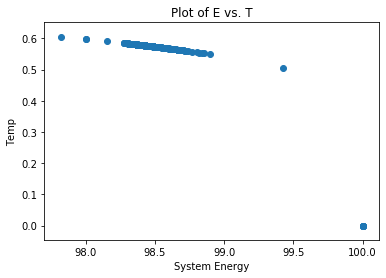

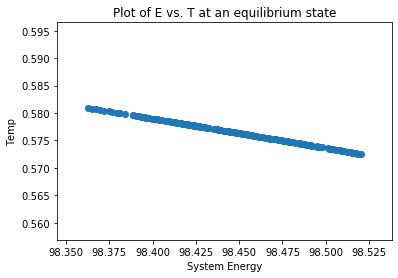

In [75]:
plt.scatter(ising_model.system_energy_data, ising_model.demon_energy_data)
plt.title('<E_d> as a function of E for B = 0')
plt.xlabel('System Energy')
plt.ylabel('Demon Energy')
plt.show()

plt.scatter(ising_model.system_energy_data, ising_model.mag_squared_data)
plt.title('<M^2> as a function of E for B = 0')
plt.xlabel('System Energy')
plt.ylabel('Magnetisation Squared')
plt.show()

plt.scatter(ising_model.system_energy_data, ising_model.temp)
plt.title('Plot of E vs. T')
plt.xlabel('System Energy')
plt.ylabel('Temp')
plt.show()

plt.scatter(ising_model.system_energy_data[250:], ising_model.temp[250:])
plt.title('Plot of E vs. T at an equilibrium state')
plt.xlabel('System Energy')
plt.ylabel('Temp')
plt.show()

### (c) Repeat the simulations in part (b) for L = 20. Run until your averages are accurate to within a few percent. Describe how the energy versus temperature changes with lattice size. ### 

I ran four Ising models with lattice sized of 20, 40, 60, and 80. The equilibrium temperature plot is replicated below. The same linear relationship is observed in the plot, only the intercept varies for each model. 

In [81]:
# Run 4 different Ising Models with different lattice sizes
ising_model_20 = IsingDemon(20, -100)
ising_model_20.initialize_system()

ising_model_40 = IsingDemon(40, -100)
ising_model_40.initialize_system()

ising_model_60 = IsingDemon(60, -100)
ising_model_60.initialize_system()

ising_model_80 = IsingDemon(80, -100)
ising_model_80.initialize_system()

# Run an Ising model with demon for 500 monte carlo steps
for i in range(500):
    ising_model_20.perterb()
    ising_model_40.perterb()
    ising_model_60.perterb()
    ising_model_80.perterb()

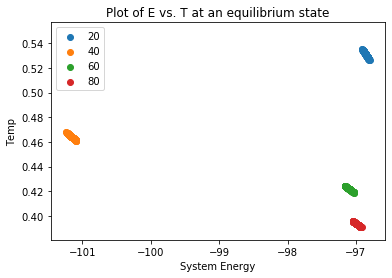

In [85]:
plt.scatter(ising_model_20.system_energy_data[250:], ising_model_20.temp[250:])
plt.scatter(ising_model_40.system_energy_data[250:], ising_model_40.temp[250:])
plt.scatter(ising_model_60.system_energy_data[250:], ising_model_60.temp[250:])
plt.scatter(ising_model_80.system_energy_data[250:], ising_model_80.temp[250:])
plt.legend(('20', '40', '60', '80'))
plt.title('Plot of E vs. T at an equilibrium state')
plt.xlabel('System Energy')
plt.ylabel('Temp')
plt.show()

### (d) Modify your program to make “snapshots” of the spin configurations. Describe the nature of the configurations at different energies or temperatures. Are they ordered or disordered? Are there domains of up or down spins? ###

The HTML animation from part (a) can be paused at any time, allowing for a sort of "snapshot" view. That configuration has with an initial target energy of -100. There is certainly a sort of order that exists with initial configurations of low (negative) system energies. Large "globs" of same spin points emerge and migrate across the domain. As I increase the inital target energy the system begins to look more chaotic and stochastic. The size of the "globs" of same-spin points are smaller. With a high enough initial target energy no long term spin patterns, or domains, in the system emerge. An example of this is shown below in an Ising model run with lattice size 50 and initial target energy 2500.

In [87]:
# Create an Ising model with a Demon
ising_model = IsingDemon(50, 2500)
ising_model.initialize_system()

# Initialize the dashboard
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
im = ax[0, 0].imshow(ising_model.lattice, cmap='Greys')
temp_line, = ax[0, 1].plot([], [], lw=3)
mag_line, = ax[1, 0].plot([], [], lw=3)
sys_energy_line, = ax[1, 1].plot([], [], lw=3)
ax[0, 0].set_title('System')
ax[0, 1].set_title('Temperature')
ax[1, 0].set_title('Magnetization')
ax[1, 1].set_title('System Energy')

# Animate the ising demon model
anim = FuncAnimation(fig, animate, interval=50, frames=250, repeat=False)
plt.close(fig)
HTML(anim.to_html5_video())